## Original AE

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

cur_path = os.getcwd()
os.makedirs('./AE', mode=0o777, exist_ok=True)
work_dir = os.getcwd() + '/AE/'
os.makedirs(work_dir + 'ckpt', mode=0o777, exist_ok=True)
ckpt_dir = work_dir + 'ckpt/'


input_img = tf.keras.Input(shape=(64, 64, 1))

hidden_num = 64

x = layers.Conv2D(hidden_num*2, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(hidden_num, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(hidden_num, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# flatten = tf.keras.layers.Flatten()(encoded)
# encoding = tf.keras.layers.Dense(50, activation="relu")(flatten)
# encoding = tf.keras.layers.Dense(50, activation="relu")(flatten)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(hidden_num, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(hidden_num, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(hidden_num*2, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
# decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoded = layers.Conv2D(1, (3, 3), padding='same')(x)

opt = Adam(lr = 0.0003)
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer=opt, loss='mse')

In [2]:
decoded

<tf.Tensor 'conv2d_6/Identity:0' shape=(None, 64, 64, 1) dtype=float32>

In [3]:
encoded

<tf.Tensor 'max_pooling2d_2/Identity:0' shape=(None, 8, 8, 48) dtype=float32>

Train on 450 samples, validate on 50 samples
Epoch 1/1000
450/450 [==============================] - 2s 4ms/sample - loss: 0.0038 - val_loss: 0.0016
Epoch 2/1000
450/450 [==============================] - 0s 264us/sample - loss: 0.0023 - val_loss: 0.0017
Epoch 3/1000
450/450 [==============================] - 0s 237us/sample - loss: 0.0020 - val_loss: 0.0016
Epoch 4/1000
450/450 [==============================] - 0s 233us/sample - loss: 0.0021 - val_loss: 0.0015
Epoch 5/1000
450/450 [==============================] - 0s 245us/sample - loss: 0.0019 - val_loss: 0.0015
Epoch 6/1000
450/450 [==============================] - 0s 237us/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 7/1000
450/450 [==============================] - 0s 239us/sample - loss: 0.0018 - val_loss: 0.0013
Epoch 8/1000
450/450 [==============================] - 0s 234us/sample - loss: 0.0017 - val_loss: 0.0013
Epoch 9/1000
450/450 [==============================] - 0s 253us/sample - loss: 0.0017 - val_loss: 0.0013
Epo

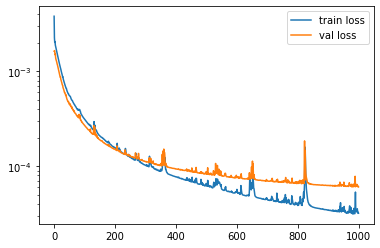

In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf

cur_path = os.getcwd()



# x_train = np.load(cur_path + '/data/inputs_500.npy')[:, :, :, None]
# x_train = np.load(cur_path + '/data/inputs_500.npy')[:, :, :, None][:, ::4, ::4, :]

x_train = np.load(cur_path + '/data/power_maps_0_500_64.npz')['arr_0'][:, :, :, None][:, ::4, ::4, :]
P_max = x_train.max()
P_min = x_train.min()
x_train = (x_train - P_min) / (P_max - P_min)

test_idx = np.random.choice(x_train.shape[0], x_train.shape[0]//10, replace=False)
train_idx = np.setxor1d(np.arange(x_train.shape[0]), test_idx)

my_callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_dir + 'model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir = work_dir + '/logs'),
]

history = autoencoder.fit(x_train[train_idx, :,:,:], x_train[train_idx, :,:,:],
                epochs=1000,
                batch_size=128,
                shuffle=True,
                validation_data=(x_train[test_idx, :,:,:], x_train[test_idx, :,:,:]),
                )


train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(train_loss)
ax.semilogy(val_loss)
ax.legend(['train loss', 'val loss'])
plt.savefig(work_dir + 'loss')

In [6]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 128)       1280      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0   


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



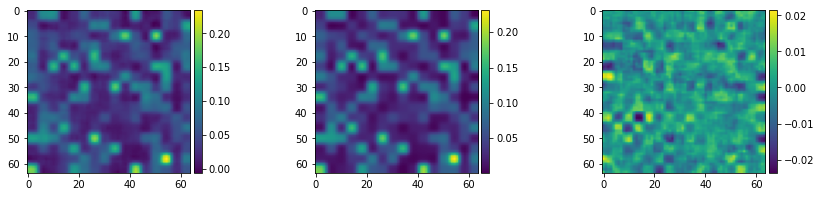

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


idx = np.random.choice(x_train.shape[0])

pred = autoencoder(x_train[idx:idx+1, :, :, :])

fig = plt.figure(figsize=(15,3))
plt.subplots_adjust(wspace=0.1)
ax = fig.add_subplot(131)
im = ax.imshow(pred[0, :, :])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax)

ax = fig.add_subplot(132)
im = ax.imshow(x_train[idx, :, :])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax)

ax = fig.add_subplot(133)
im = ax.imshow((x_train[idx, :, :] - pred[0, :, :]))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax)


In [63]:
x_train[idx, :, :].min()

0.0002029701859883668

In [4]:
import numpy as np
import os
test_data = np.load(os.getcwd() + '/data/inputs_500.npy')

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]

In [3]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True